In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import itertools, glob, os

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm

import random
random.seed(42)

import numpy as np

from torch.autograd import Variable

from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define:

In [10]:
DATASET_FOLDER_PATH = "/content/drive/MyDrive/Cat2Tiger/Dataset"
DATASET_NAME = 'cat2tiger'
WEIGHT_PATH = '/content/drive/MyDrive/Cat2Tiger/weight'

DATASET_PATH = DATASET_FOLDER_PATH + '/' + DATASET_NAME

# size of image
img_height = img_width = 256

n_workers = 2
batch_size = 4

start_epoch = 28
end_epoch = 30

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Models

In [60]:
class ResidualBlock(nn.Module):
  def __init__(self, in_features):
    super(ResidualBlock, self).__init__()

    self.block = nn.Sequential(nn.ReflectionPad2d(1),
                                nn.Conv2d(in_features, in_features, 3),
                                nn.InstanceNorm2d(in_features),
                                nn.ReLU(inplace=True),
                                nn.ReflectionPad2d(1),
                                nn.Conv2d(in_features, in_features, 3),
                                nn.InstanceNorm2d(in_features))

  def forward(self, x):
    return x + self.block(x)

class Generator(nn.Module):

  def __init__(self, in_channels = 3, n_residual_blocks = 3, n_conv_blocks = 3):
    super(Generator, self).__init__()

    out_features = 256 // (2  ** (n_conv_blocks-1)) # 64

    model = [nn.ReflectionPad2d(in_channels),
             nn.Conv2d(in_channels, out_features, 7),
             nn.InstanceNorm2d(out_features),
             nn.ReLU(inplace=True)]

    n_conv_blocks -= 1
    in_features = out_features

    for _ in range(n_conv_blocks):
      out_features = 2 * in_features
      model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)]
      in_features = out_features

    for _ in range(n_residual_blocks):
      model += [ResidualBlock(out_features)]

    for _ in range(2):
      out_features = in_features // 2
      model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)]
      in_features = out_features

    model += [nn.ReflectionPad2d(3), 
              nn.Conv2d(out_features, in_channels, 7), 
              nn.Tanh()]

    self.model = nn.Sequential(*model)

  def forward(self, x):
      return self.model(x)

In [59]:
class Discriminator(nn.Module):
  def conv_block_lrelu(self, in_filters, out_filters, normalize=True):
    layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
    if normalize: layers.append(nn.InstanceNorm2d(out_filters))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

  def __init__(self, input_nc = 3, conv_layers = 5):
    super(Discriminator, self).__init__()

    out_filters = 64

    model = [nn.Conv2d(input_nc, out_filters, 4, stride=2, padding=1),
             nn.LeakyReLU(0.2, inplace=True)]
    
    for i in range(conv_layers - 3):
      in_filters = out_filters
      out_filters = in_filters * 2
      model += [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1),
                nn.InstanceNorm2d(out_filters),
                nn.LeakyReLU(0.2, inplace=True)]

    model += [  nn.Conv2d(256, 512, 4, padding=1),
                nn.InstanceNorm2d(512), 
                nn.LeakyReLU(0.2, inplace=True) ]

    model += [nn.Conv2d(512, 1, 4, padding=1)]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    x = self.model(x)
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.flatten(start_dim=1)
    return x

In [71]:
# # Test output generator and discriminator
# G = Generator2(3, 6, 3)
# # D = Discriminator(3)

# X = torch.randn(1,3,256,256)
# print(G(X).shape)
# del X, G

torch.Size([1, 64, 256, 256])


# Prepare dataset:

In [7]:
class ImageDataset(Dataset):
  def __init__(self, img_path, transforms_= None, unaligned = False, mode = "train"):
    self.transform = transforms.Compose(transforms_)
    self.unaligned = unaligned
    # self.files_A = sorted(glob.glob(os.path.join(img_path, f"{mode}A") + "/*.*"))
    # self.files_B = sorted(glob.glob(os.path.join(img_path, f"{mode}B") + "/*.*"))
    self.files_A = sorted(glob.glob(os.path.join(img_path, f"A") + "/*.*"))
    self.files_B = sorted(glob.glob(os.path.join(img_path, f"B") + "/*.*"))

  def __getitem__(self, index):
    image_A = Image.open(self.files_A[index % len(self.files_A)])

    if self.unaligned:
        image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
    else:
        image_B = Image.open(self.files_B[index % len(self.files_B)])

    item_A = self.transform(image_A)
    item_B = self.transform(image_B)
    return {"A": item_A, "B": item_B}

  def __len__(self):
    return max(len(self.files_A), len(self.files_B))

In [11]:
transforms_ = [transforms.Resize(int(img_height * 1.12), transforms.functional.InterpolationMode.BICUBIC),
               transforms.RandomCrop((img_height, img_width)),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

train_dataset = ImageDataset(DATASET_PATH, transforms_=transforms_, unaligned=True, mode = "train" );
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)

print(len(train_dataset))

1124


In [ ]:
# Show batch sample

# batch = next(iter(train_dataloader))
# batch['A'].shape, batch['B'].shape

# A = batch['A']
# with torch.no_grad():
#   G_AB.eval()
#   G_BA.eval()
#   Bfake = G_AB(A)
#   Arec = G_BA(Bfake)

# print(A.shape, A.min(), A.mean(), A.max())
# print(Bfake.shape, Bfake.min(), Bfake.mean(), Bfake.max())
# print(Arec.shape, Arec.min(), Arec.mean(), Arec.max())

# plt.figure(figsize=(10,6))

# for i in range(len(A)):
#   plt.subplot(3, 4, i+1)
#   plt.axis('off')
#   plt.imshow(denorm(A[i]).permute(1, 2, 0))

#   plt.subplot(3, 4, i+1+4)
#   plt.axis('off')
#   plt.imshow(denorm(Bfake[i]).permute(1, 2, 0))

#   plt.subplot(3, 4, i+1+8)
#   plt.axis('off')
#   plt.imshow(denorm(Arec[i]).permute(1, 2, 0))
  
# plt.show()

# Utils:

In [12]:
def denorm(x, mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]):
  mean = torch.tensor(mean)
  std = torch.tensor(std)
  return transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())(x)

def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, "bias") and m.bias is not None:
      torch.nn.init.constant_(m.bias.data, 0.0)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

def allocated_GPU_memory():
  torch.cuda.empty_cache()
  return round(torch.cuda.memory_allocated() / (10 ** 6) , 2)

In [13]:
class ReplayBuffer():
  def __init__(self, max_size = 50):
    assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
    self.max_size = max_size
    self.data = []

  def push_and_pop(self, data):
    to_return = []
    for element in data.data:
      element = torch.unsqueeze(element, 0)
      if len(self.data) < self.max_size:
        self.data.append(element)
        to_return.append(element)
      else:
        if random.uniform(0,1) > 0.5:
          i = random.randint(0, self.max_size-1)
          to_return.append(self.data[i].clone())
          self.data[i] = element
        else:
          to_return.append(element)
    return Variable(torch.cat(to_return))

In [14]:
def save_checkpoint(epoch, G_AB, G_BA, D_A, D_B, WEIGHT_PATH):
  torch.save(G_AB.state_dict(), f'{WEIGHT_PATH}/{epoch}_G_AB.pth')
  torch.save(G_BA.state_dict(), f'{WEIGHT_PATH}/{epoch}_G_BA.pth')
  torch.save(D_A.state_dict(), f'{WEIGHT_PATH}/{epoch}_D_A.pth')
  torch.save(D_B.state_dict(), f'{WEIGHT_PATH}/{epoch}_D_B.pth')

def load_checkpoint(epoch, G_AB, G_BA, D_A, D_B, WEIGHT_PATH):
  G_AB.load_state_dict(torch.load(f'{WEIGHT_PATH}/{epoch}_G_AB.pth', map_location=device))
  G_BA.load_state_dict(torch.load(f'{WEIGHT_PATH}/{epoch}_G_BA.pth', map_location=device))
  D_A.load_state_dict(torch.load(f'{WEIGHT_PATH}/{epoch}_D_A.pth', map_location=device))
  D_B.load_state_dict(torch.load(f'{WEIGHT_PATH}/{epoch}_D_B.pth', map_location=device))

In [36]:
def showimages(A, Bfake, Arec):
  plt.figure(figsize=(10,6))

  for i in range(len(A)):
    plt.subplot(3, 4, i+1)
    plt.axis('off')
    plt.imshow(denorm(A[i]).permute(1, 2, 0))
    plt.title('Original')

    plt.subplot(3, 4, i+1+4)
    plt.axis('off')
    plt.imshow(denorm(Bfake[i]).permute(1, 2, 0))
    plt.title(f'Fake')

    plt.subplot(3, 4, i+1+8)
    plt.axis('off')
    plt.imshow(denorm(Arec[i]).permute(1, 2, 0))
    plt.title('Reconstruct')

def convert(Gen_AB, Gen_BA, A, plot = True): #, D = None):
  with torch.no_grad():
    Gen_AB.eval(); Gen_BA.eval()
    Bfake = Gen_AB(A.to(device))
    Arec = Gen_BA(Bfake)
    A = A.to('cpu'); Bfake = Bfake.to('cpu'); Arec = Arec.to('cpu')
  if plot: showimages(A, Bfake, Arec)
  else: return Bfake, Arec

# Load models, loss, criterion:

In [16]:
G_AB = Generator(3, 6, 3).to(device)
G_BA = Generator(3, 6, 3).to(device)
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

allocated_GPU_memory()

86.66

In [46]:
# Load or init weight
if start_epoch:
  load_checkpoint(start_epoch, G_AB, G_BA, D_A, D_B, WEIGHT_PATH)
  print(f'Loaded weight (epoch {start_epoch})')
else:
  G_AB.apply(weights_init_normal)
  G_BA.apply(weights_init_normal)
  D_A.apply(weights_init_normal)
  D_B.apply(weights_init_normal)
  print('Init normal weight)')
  
allocated_GPU_memory()

Loaded weight (epoch 28)


567.34

In [19]:
# lr = 0.00012
# lr = 0.0002
lr = 0.0001
b1 = 0.5
b2 = 0.999

lambda_cyc = 10.0
lambda_id = 0.0

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

allocated_GPU_memory()

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Train

Epoch: 30 , Loss G: 1.4107 , Loss D_A: 0.135 , Loss D_A: 0.1134


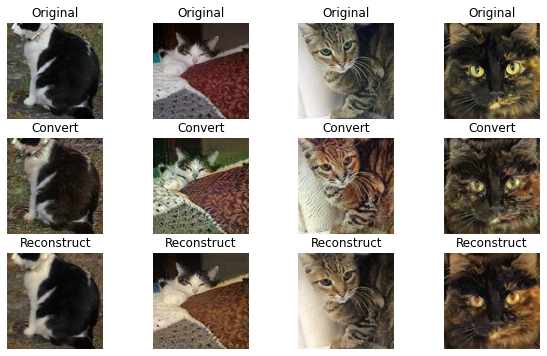

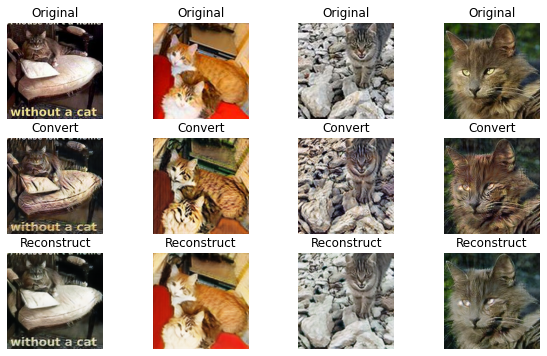

In [29]:
auto_save = True
showimage = True

for epoch in range(start_epoch, end_epoch):
  
  epoch += 1
  log_loss_G = []
  log_loss_D_A = []
  log_loss_D_B = []

  tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
  for batch_idx, batch in enumerate(tqdm_bar):

    G_AB.train()
    G_BA.train()
    D_A.train()
    D_B.train()
    optimizer_G.zero_grad()
    
    A_real = batch["A"].float().to(device)
    B_real = batch["B"].float().to(device)
    valid = torch.ones((len(A_real), 1), dtype=torch.float, requires_grad=False).to(device)
    fake = torch.zeros((len(A_real), 1), dtype=torch.float, requires_grad=False).to(device)

    # Train Generators

    B_fake  = G_AB(A_real)
    A_fake = G_BA(B_real)

    # GAN loss
    loss_GAN_AB = criterion_GAN(D_B(B_fake), valid)
    loss_GAN_BA = criterion_GAN(D_A(A_fake), valid)
    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

    # Identity loss
    loss_id_A = criterion_identity(G_BA(A_real), A_real)
    loss_id_B = criterion_identity(G_AB(B_real), B_real)
    loss_identity = (loss_id_A + loss_id_B) / 2

    # Cycle loss
    loss_cycle_A = criterion_cycle(G_BA(B_fake), A_real)
    loss_cycle_B = criterion_cycle(G_AB(A_fake), B_real)
    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

    # Total loss
    loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
    loss_G.backward()
    optimizer_G.step()

    loss_identity = loss_identity.to('cpu')
    loss_GAN = loss_GAN.to('cpu')
    loss_cycle = loss_cycle.to('cpu')
    del loss_GAN, loss_identity, loss_cycle
    torch.cuda.empty_cache()

    log_loss_G.append(loss_G.item())
    loss_G = loss_G.to('cpu')
    del loss_G
    torch.cuda.empty_cache()

    # Train Discriminator A
    optimizer_D_A.zero_grad()

    A_fake = fake_A_buffer.push_and_pop(A_fake)
    loss_real = criterion_GAN(D_A(A_real), valid)
    loss_fake = criterion_GAN(D_A(A_fake.detach()), fake)
    loss_D_A = (loss_real + loss_fake) / 2

    loss_D_A.backward()
    optimizer_D_A.step()

    loss_real = loss_real.to('cpu')
    loss_fake = loss_fake.to('cpu')
    del loss_real, loss_fake
    torch.cuda.empty_cache()

    log_loss_D_A.append(loss_D_A.item())
    loss_D_A = loss_D_A.to('cpu')
    del loss_D_A
    torch.cuda.empty_cache()
    
    # Train Discriminator B
    optimizer_D_B.zero_grad()

    B_fake = fake_B_buffer.push_and_pop(B_fake)
    loss_real = criterion_GAN(D_B(B_real), valid)
    loss_fake = criterion_GAN(D_B(B_fake.detach()), fake)
    loss_D_B = (loss_real + loss_fake) / 2

    loss_D_B.backward()
    optimizer_D_B.step()

    loss_real = loss_real.to('cpu')
    loss_fake = loss_fake.to('cpu')
    del loss_real, loss_fake
    torch.cuda.empty_cache()

    log_loss_D_B.append(loss_D_B.item())
    loss_D_B = loss_D_B.to('cpu')
    del loss_D_B
    torch.cuda.empty_cache()

    A_real = A_real.to('cpu'); B_real = B_real.to('cpu')
    A_fake = A_fake.to('cpu'); B_fake = B_fake.to('cpu')
    valid = valid.to('cpu'); fake = fake.to('cpu')
    del A_real, B_real
    del A_fake, B_fake
    del valid, fake
    torch.cuda.empty_cache()

  clear_output(wait=True)

  log_loss_G = np.array(log_loss_G).mean().round(4)
  log_loss_D_A = np.array(log_loss_D_A).mean().round(4)
  log_loss_D_B = np.array(log_loss_D_B).mean().round(4)
  print('Epoch:', epoch, ', Loss G:', log_loss_G, ', Loss D_A:', log_loss_D_A, ', Loss D_A:', log_loss_D_B)

  # break

  if auto_save:
    if not epoch % 2 and epoch != 0:
      save_checkpoint(epoch, G_AB, G_BA, D_A, D_B, WEIGHT_PATH)

  if showimage:
    batch = next(iter(train_dataloader))
    convert(G_AB, G_BA, batch['A'], plot = True)

  torch.cuda.empty_cache()

# Show result:

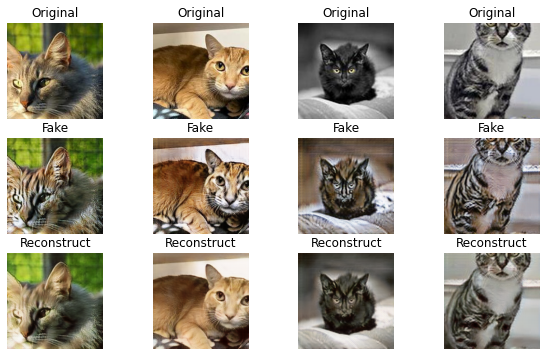

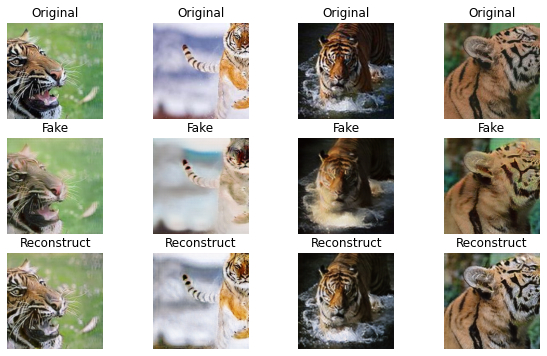

In [48]:
batch = next(iter(train_dataloader))

A = batch['A']
convert(G_AB, G_BA, A, plot = True)

B = batch['B']
convert(G_BA, G_AB, B, plot = True)